***Fichier de création du model K-mean***

*chargement des données depuis MongoDB*

In [1]:
from pymongo import MongoClient
import pandas as pd

# Connexion à MongoDB
client = MongoClient("mongodb://127.0.0.1:27017")
db = client["my_database"]
collection = db["my_collection"]

# Charger les données
data = list(collection.find({}, {"_id": 0, "Nom du dépôt": 1, "Topics": 1, "Description": 1, "README": 1}))

# Convertir en DataFrame Pandas
df = pd.DataFrame(data)
df["combined_text"] = df["Nom du dépôt"] + " " + df["Topics"].apply(lambda x: " ".join(x) if isinstance(x, list) else "") + " " + df["Description"] + " " + df["README"]


*Prétraiter les données textuelles*

In [2]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords de nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    tokens = text.split()  # Tokeniser
    tokens = [word for word in tokens if word not in stop_words]  # Supprimer les stopwords
    return " ".join(tokens)

# Appliquer le nettoyage
df["cleaned_text"] = df["combined_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Transformer le texte en vecteurs d'embedding*

In [3]:
#Avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limite les dimensions
X1 = vectorizer.fit_transform(df["cleaned_text"]).toarray()

#Avec sentence-transformers
from sentence_transformers import SentenceTransformer

# Charger un modèle de Sentence Transformers - embeddings plus riches
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir les textes en embeddings
X = model.encode(df["cleaned_text"].tolist())

*Appliquer l'algorithme K-Means*

C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_

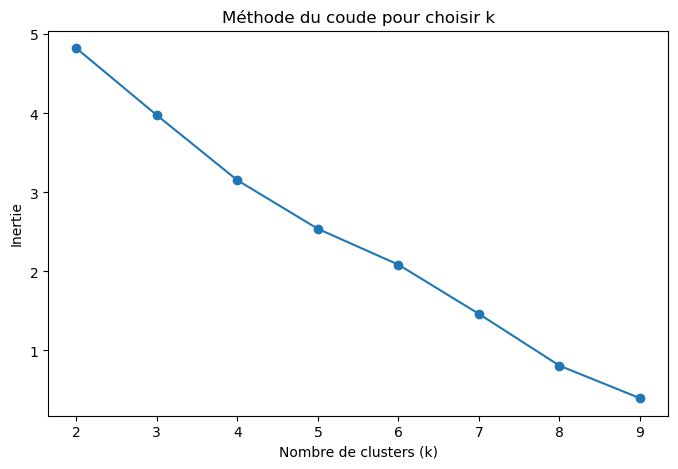

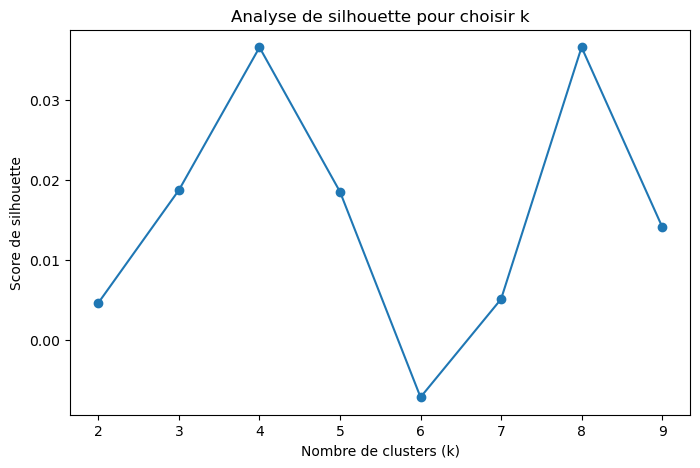

Le nombre optimal de clusters selon l'analyse de silhouette est : 4


C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os

os.environ["OMP_NUM_THREADS"] = "1"  # Pour éviter les erreurs de leak de mémoire sur Windows

# Déterminer le nombre optimal de clusters avec la silhouette analysis
silhouette_scores = []
inertia = []
K = range(2, min(10, X.shape[0] + 1))  # Limiter K au nombre d'échantillons

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    inertia.append(kmeans.inertia_)


# Tracer la courbe d'inertie
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour choisir k')
plt.show()



# Tracer le score de silhouette pour chaque k
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Analyse de silhouette pour choisir k')
plt.show()



# Trouver le k optimal
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]

#test à supprimer avec k=4
optimal_k = 4

print(f"Le nombre optimal de clusters selon l'analyse de silhouette est : {optimal_k}")

# Appliquer K-Means avec le k optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["cluster"] = kmeans.fit_predict(X)


*Interpréter les résultats*

In [5]:
# Afficher les données regroupées par cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster][["Nom du dépôt"]])



Cluster 0:
       Nom du dépôt
2           awesome
3  build-your-own-x
9             react

Cluster 1:
           Nom du dépôt
4           public-apis
7  system-design-primer

Cluster 2:
                  Nom du dépôt
0                 freeCodeCamp
1       free-programming-books
5  coding-interview-university
6            developer-roadmap

Cluster 3:
  Nom du dépôt
8      996.ICU


*Visualisation*

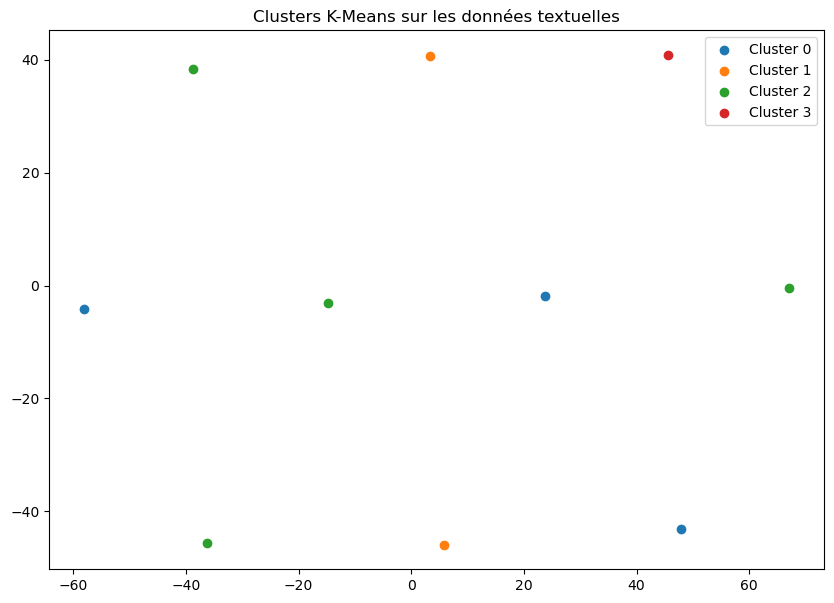

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Vérifier la taille des données
n_samples = X.shape[0]
perplexity = min(30, n_samples - 1)  # La perplexité doit être inférieure au nombre d'échantillons

# Réduction de dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
X_2d = tsne.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means sur les données textuelles")
plt.show()


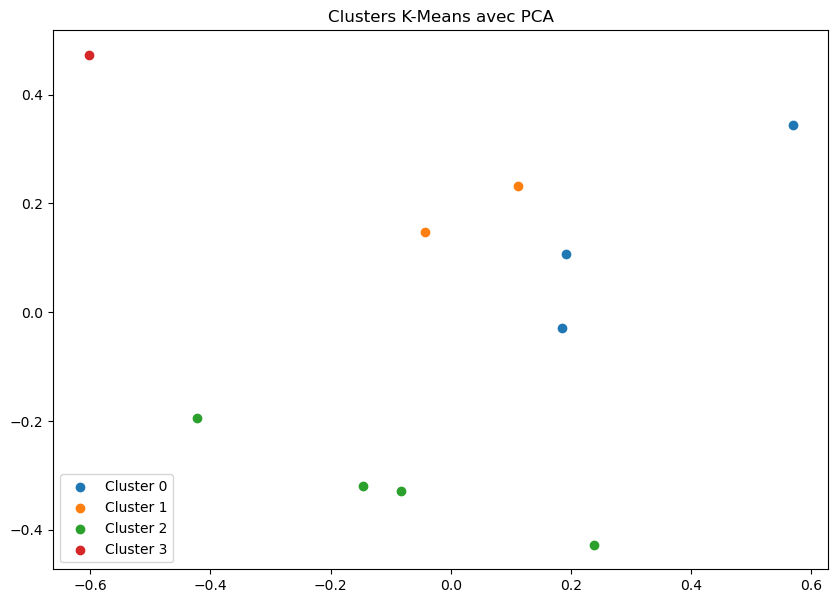

In [11]:
from sklearn.decomposition import PCA

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means avec PCA")
plt.show()


*Mise en place des résulats sur MongoDB*

In [13]:
#print(X,"\n")
#print(df["cleaned_text"].head())

***Fichier du model de création de thème par cluster***

In [14]:
import numpy as np

# Exemple : Liste des vecteurs d'embedding et des clusters
# X est une matrice d'embedding où chaque ligne correspond à un vecteur
# df['cluster'] contient les étiquettes des clusters
clusters = df["cluster"].unique()
cluster_embeddings = {cluster: X[df["cluster"] == cluster] for cluster in clusters}


In [15]:
# Calculer le vecteur central pour chaque cluster
cluster_centroids = {
    cluster: np.mean(embeddings, axis=0)
    for cluster, embeddings in cluster_embeddings.items()
}


In [23]:
from sentence_transformers import SentenceTransformer

# Charger un modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Liste de mots de vocabulaire potentiellement pertinents (vous pouvez personnaliser)
vocabulary = ["programming", "API", "machine learning", "JavaScript", "Python", "database", "web"]

# Embeddings des mots du vocabulaire
vocabulary_embeddings = sentence_model.encode(vocabulary)

# Trouver le mot le plus proche pour chaque cluster
cluster_themes = {}
for cluster, centroid in cluster_centroids.items():
    similarities = np.dot(vocabulary_embeddings, centroid)  # Produit scalaire
    best_match_index = np.argmax(similarities)  # Indice du mot le plus proche
    cluster_themes[cluster] = vocabulary[best_match_index]

print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")

Thèmes des clusters :
Cluster 2: programming
Cluster 0: programming
Cluster 1: API
Cluster 3: programming


In [17]:
%pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-win_amd64.whl (24.0 MB)
                                              0.0/61.7 kB ? eta -:--:--
     ------                                   10.2/61.7 kB ? eta -:--:--
     -------------------------------        51.2/61.7 kB 518.5 kB/s eta 0:00:01
     -------------------------------------- 61.7/61.7 kB 547.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
